# Project 2

## Setup 

Download the data from the worldbank

In [2]:
# download and update the data in the project
!./setup.sh 

mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘report/data’: File exists
mkdir: cannot create directory ‘report/images’: File exists
Archive:  data/GHS-2023-PERSON.zip


In [3]:
!pip install -r requirements.txt

In [4]:
import pandas as pd
import scipy.stats as stats
from scipy.stats import shapiro
from scipy.stats import kruskal
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.api as sms

import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix

file_output = "report/data"
image_output = "report/images"

In [5]:
education_level_labels = [
    "Grade R/0",
    "Grade 1/Sub A/Class 1",
    "Grade 2/Sub B/Class 2",
    "Grade 3/Standard 1/ABET/AET 1",
    "Grade 4/Standard 2",
    "Grade 5/Standard 3/ABET/AET 2",
    "Grade 6/Standard 4",
    "Grade 7/Standard 5/ABET/AET 3",
    "Grade 8/Standard 6/Form 1",
    "Grade 9/Standard 7/Form 2/ABET/AET 4/NCV Level 1/OCCUPATIONAL CERTIFICATE - NQF LEVEL 1",
    "Grade 10/Standard 8/Form 3/NCV Level 2/OCCUPATIONAL CERTIFICATE – NQF LEVEL 2",
    "Grade 11/Standard 9/Form 4/NCV Level 3/OCCUPATIONAL CERTIFICATE – NQF LEVEL 3",
    "Grade 12/Standard 10/Form 5/National Senior Certificate/Matric/NCV Level 4/OCCUPATIONAL CERTIFICATE – NQF LEVEL 4",
    "NTC L/N1/NQF 1",
    "NTC LL/N2/NQF 2",
    "NTC LLL/N3/NQF 3",
    "N4/NTC 4/OCCUPATIONAL CERTIFICATE – NQF LEVEL 5",
    "N5/NTC 5/OCCUPATIONAL CERTIFICATE – NQF LEVEL 5",
    "N6/NTC 6/OCCUPATIONAL CERTIFICATE – NQF LEVEL 5",
    "Certificate with Less Than Grade 12/Standard 10",
    "Diploma with Less Than Grade 12/Standard 10",
    "Higher/National/Advance Certificate with Grade 12/Std 10/OCCUPATIONAL CERTIFICATE – NQF LEVEL 5",
    "Diploma with Grade 12/Standard 10/OCCUPATIONAL CERTIFICATE – NQF LEVEL 6",
    "Higher Diploma/OCCUPATIONAL CERTIFICATE (B-Tech Diploma) – NQF LEVEL 7",
    "Bachelor’s Degree/OCCUPATIONAL CERTIFICATE – NQF LEVEL 7",
    "Honours Degree/Postgraduate Diploma/OCCUPATIONAL CERTIFICATE – NQF LEVEL 8",
    "Post Higher Diploma (M-Tech and Master's Degree) – NQF LEVEL 9",
    "Doctoral Degrees (D-Tech and PhD) – NQF LEVEL 10",
    "Other Than Any of the Above",
    "Do Not Know",
]

other_education_labels = {
    98: "No Schooling",
    99: "Unspecified"
}

employment_labels = {
    1: "Employed",
    2: "Unemployed",
    3: "Not economically active",
    8: "Not applicable"
}

education_bins = {
    0: "No Formal Education",
    1: "Basic Education",
    2: "Intermediate Education",
    3: "Secondary Education",
    4: "Vocational Education",
    5: "Tertiary Education",
}
bin_mapping = {
    "No Schooling": 0,
    "Grade R/0": 1,
    "Grade 1/Sub A/Class 1": 1,
    "Grade 2/Sub B/Class 2": 1,
    "Grade 3/Standard 1/ABET/AET 1": 1,
    "Grade 4/Standard 2": 2,
    "Grade 5/Standard 3/ABET/AET 2": 2,
    "Grade 6/Standard 4": 2,
    "Grade 7/Standard 5/ABET/AET 3": 2,
    "Grade 8/Standard 6/Form 1": 2,
    "Grade 9/Standard 7/Form 2/ABET/AET 4/NCV Level 1/OCCUPATIONAL CERTIFICATE - NQF LEVEL 1": 3,
    "Grade 10/Standard 8/Form 3/NCV Level 2/OCCUPATIONAL CERTIFICATE – NQF LEVEL 2": 3,
    "Grade 11/Standard 9/Form 4/NCV Level 3/OCCUPATIONAL CERTIFICATE – NQF LEVEL 3": 3,
    "Grade 12/Standard 10/Form 5/National Senior Certificate/Matric/NCV Level 4/OCCUPATIONAL CERTIFICATE – NQF LEVEL 4": 3,
    "NTC L/N1/NQF 1": 4,
    "NTC LL/N2/NQF 2": 4,
    "NTC LLL/N3/NQF 3": 4,
    "N4/NTC 4/OCCUPATIONAL CERTIFICATE – NQF LEVEL 5": 4,
    "N5/NTC 5/OCCUPATIONAL CERTIFICATE – NQF LEVEL 5": 4,
    "N6/NTC 6/OCCUPATIONAL CERTIFICATE – NQF LEVEL 5": 4,
    "Certificate with Less Than Grade 12/Standard 10": 3,
    "Diploma with Less Than Grade 12/Standard 10": 3,
    "Higher/National/Advance Certificate with Grade 12/Std 10/OCCUPATIONAL CERTIFICATE – NQF LEVEL 5": 5,
    "Diploma with Grade 12/Standard 10/OCCUPATIONAL CERTIFICATE – NQF LEVEL 6": 5,
    "Higher Diploma/OCCUPATIONAL CERTIFICATE (B-Tech Diploma) – NQF LEVEL 7": 5,
    "Bachelor’s Degree/OCCUPATIONAL CERTIFICATE – NQF LEVEL 7": 5,
    "Honours Degree/Postgraduate Diploma/OCCUPATIONAL CERTIFICATE – NQF LEVEL 8": 5,
    "Post Higher Diploma (M-Tech and Master's Degree) – NQF LEVEL 9": 5,
    "Doctoral Degrees (D-Tech and PhD) – NQF LEVEL 10": 5,
}


In [6]:
df = pd.read_csv("data/GHS-2023-PERSON_F1.csv")
print(df.isnull().sum())

columns_to_convert = ['psu','employ_Status2','lab_amount','lab_sto', 'prov', 'Sex', 'age', 'age_grp1', 'hhc_relationship']  # Add more as needed
df[columns_to_convert] = df[columns_to_convert].apply(pd.to_numeric, errors='coerce')

df["education-name"] = df['education'].map(lambda x: education_level_labels[x] if x < len(education_level_labels) else other_education_labels[x] if x in other_education_labels.keys() else None)

sex_mapping = {1: 'Male', 2: 'Female'}
df['Sex'] = df['Sex'].map(sex_mapping)
df = df.dropna()

uqnr              0
personnr          0
psu               0
prov              0
Four_by_Four      0
                 ..
lab_salary        0
employ_Status1    0
employ_Status2    0
rotation          0
person_wgt        0
Length: 112, dtype: int64


**Hypothesis 1: Does Education Level Affect Income?**
 - **Null Hypothesis (H₀)**: Education level does not significantly affect the likelihood of earning more than $50K per year.
 - **Alternative Hypothesis (H₁)**: Education level significantly affects the likelihood of earning more than $50K per year.
    
To test this hypothesis, we performed a chi-square test of independence. Since both education level and income are categorical variables, the chi-square test is appropriate to evaluate whether there is a statistically significant association between these variables. Additionally, a logistic regression model was used to assess the predictive power of education level on income.

In [7]:
#clean and prepare data

# filter the data by those who were willing to disclose their earnings
income_data = df[(df['employ_Status2'] <= 2) & (df['education'] != 29) & (df['education'] != 99 )]
# income_data
income_data['education_category'] = income_data['education-name'].map(bin_mapping)

/tmp/ipykernel_131688/3971188269.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  income_data['education_category'] = income_data['education-name'].map(bin_mapping)


In [8]:
print(income_data.groupby(['education_category', 'employ_Status2'])['uqnr'].count())
print(income_data.groupby(['age', 'employ_Status2'])['uqnr'].count())

education_category  employ_Status2
0.0                 1                   230
                    2                    97
1.0                 1                   209
                    2                   107
2.0                 1                  1920
                    2                  1174
3.0                 1                 12336
                    2                  7749
4.0                 1                   450
                    2                   227
5.0                 1                  3705
                    2                   649
Name: uqnr, dtype: int64
age  employ_Status2
15   1                  3
     2                 19
16   1                  4
     2                 22
17   1                 10
                       ..
80   1                  4
81   1                  1
82   1                  4
83   1                  1
89   1                  2
Name: uqnr, Length: 129, dtype: int64


In [9]:
# # create a contingency table between education and income
contingency_table = pd.crosstab(income_data['education_category'], income_data['employ_Status2'])
# contingency_table.columns = ['<=50K', '>50K']

# with open(f"{file_output}/hyp1_cont_table.tex", "w") as f:
#     latex_table = contingency_table.to_latex()
#     f.write(latex_table)

contingency_table

employ_Status2,1,2
education_category,,
0.0,230,97
1.0,209,107
2.0,1920,1174
3.0,12336,7749
4.0,450,227
5.0,3705,649


In [10]:
# perform chi squared
chi2 = stats.chi2_contingency(contingency_table)

# save results as latex table
with open(f"{file_output}/hyp_1_chi_2.tex", "w") as f:
    res = pd.DataFrame({
        r'$\chi^2': {"Value": r'{:.2f}'.format(chi2.statistic)},
        r'$p$': {"Value": r'{:.2f}'.format(chi2.pvalue)}
    })
    f.write(res.to_latex())
    # Conclusion based on the p-value

print(f"Chi-square statistic: {chi2.statistic:.2f}")
print(f"P-value: {chi2.pvalue:.4f}")

alpha = 0.05
if chi2.pvalue < alpha:
    print("Reject the null hypothesis (H₀): Education level significantly affects the likelihood being employed.")
else:
    print("Fail to reject the null hypothesis (H₀): Education level does not significantly affect the likelihood of being employed.")

Chi-square statistic: 905.29
P-value: 0.0000
Reject the null hypothesis (H₀): Education level significantly affects the likelihood being employed.


In [11]:
income_data = income_data.dropna(subset=['education_category', 'employ_Status2'])
print(income_data.groupby(['education_category'])['employ_Status2'].count())
le = LabelEncoder()
# df['income-binary'] = le.fit_transform(df['income-binary'])
# df['education-num'] = le.fit_transform(df['education-num'])
# Logistic regression with education as the independent variable and income as the dependent variable
X = sm.add_constant(income_data['education_category'])  # Add constant term
y = income_data['employ_Status2'] - 1 


# Fit logistic regression model
model = sm.Logit(y, X)
result = model.fit()

# Summary of the model
print(result.summary())

with open(f"{file_output}/hyp_1_log_summary.tex", "w") as f:
    f.write(result.summary().as_latex())

education_category
0.0      327
1.0      316
2.0     3094
3.0    20085
4.0      677
5.0     4354
Name: employ_Status2, dtype: int64
Optimization terminated successfully.
         Current function value: 0.635305
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:         employ_Status2   No. Observations:                28853
Model:                          Logit   Df Residuals:                    28851
Method:                           MLE   Df Model:                            1
Date:                Sun, 29 Sep 2024   Pseudo R-squ.:                 0.01560
Time:                        15:30:10   Log-Likelihood:                -18330.
converged:                       True   LL-Null:                       -18621.
Covariance Type:            nonrobust   LLR p-value:                2.302e-128
                         coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------

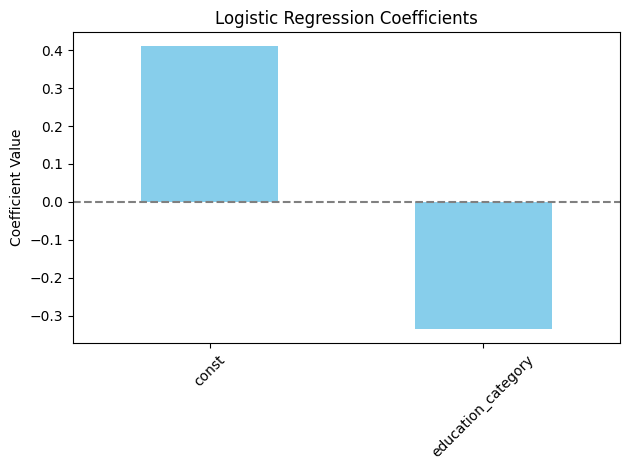

In [12]:
import matplotlib.pyplot as plt

# Prepare the coefficients for plotting
coef = result.params
coef.plot(kind='bar', color='skyblue')
plt.title('Logistic Regression Coefficients')
plt.ylabel('Coefficient Value')
plt.axhline(0, color='gray', linestyle='--')  # Reference line at 0
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig(f"{image_output}/hyp_1_log_coeff.svg", format="svg")
plt.show()



/tmp/ipykernel_131688/1473822193.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='education_category', y='predicted_prob', data=sorted_vals, ci=None, palette='Set2')
/tmp/ipykernel_131688/1473822193.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='education_category', y='predicted_prob', data=sorted_vals, ci=None, palette='Set2')


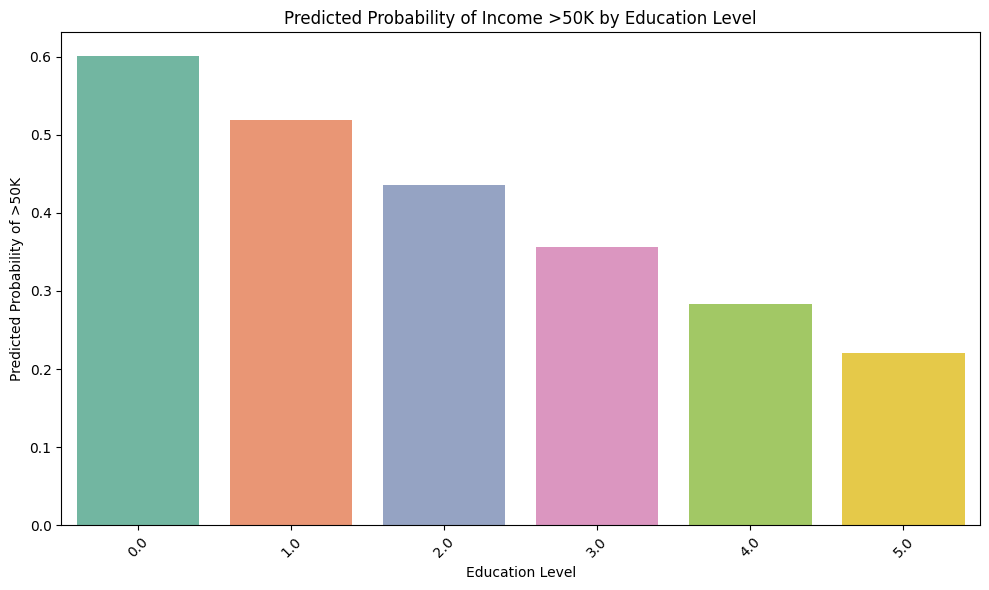

/tmp/ipykernel_131688/1473822193.py:30: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


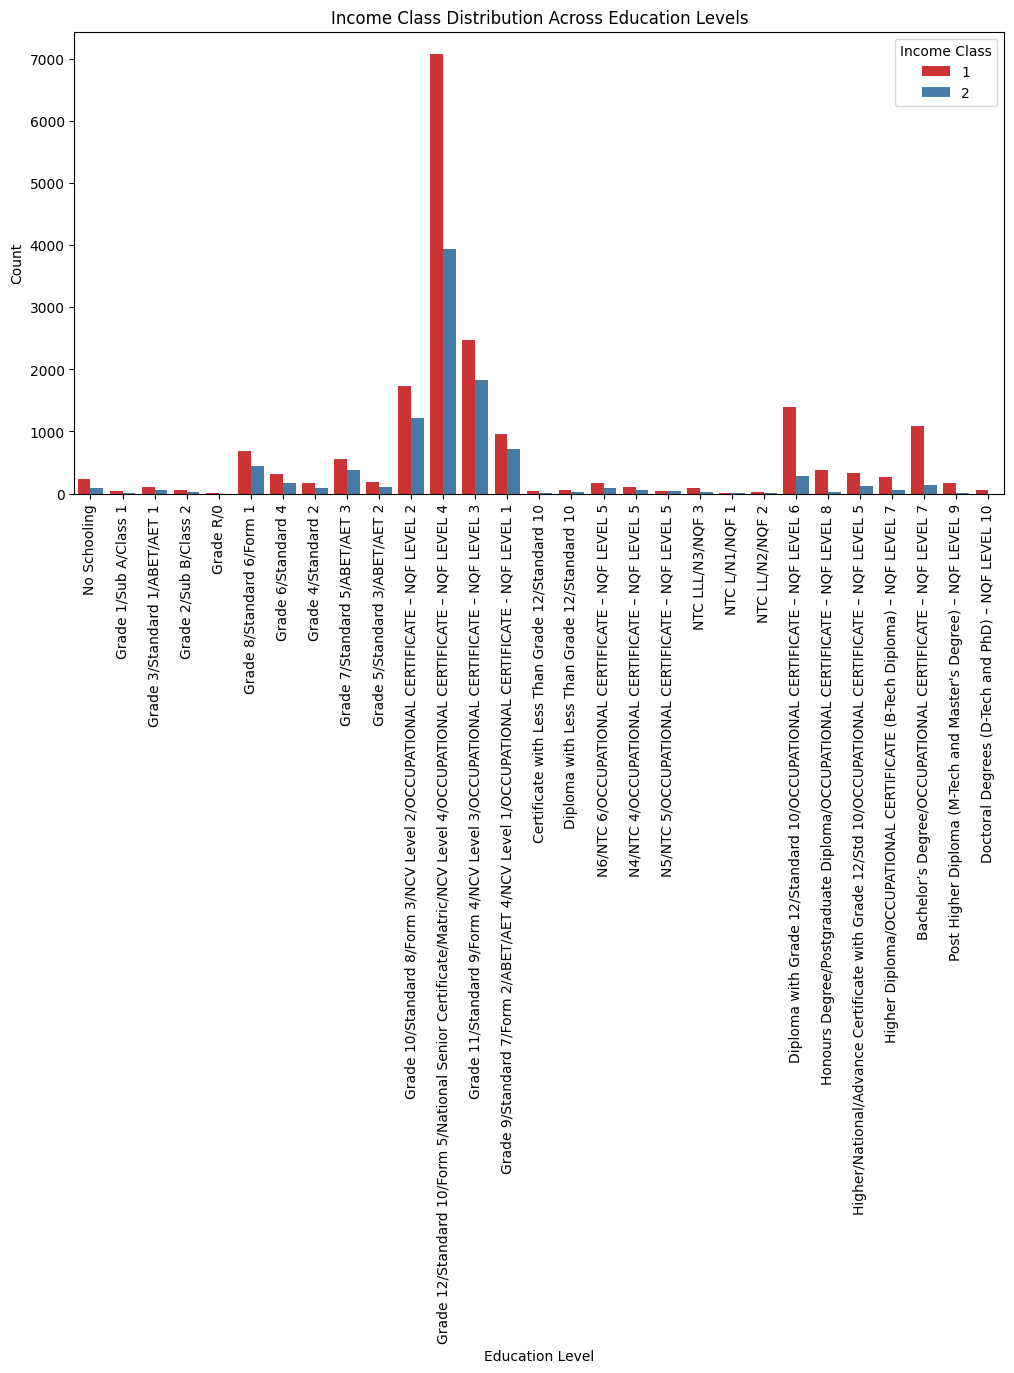

In [13]:
# Prepare the data for plotting

income_data['predicted_prob'] = result.predict(X)
sorted_vals = income_data.sort_values(by='education_category', ascending=True)


plt.figure(figsize=(10, 6))
sns.barplot(x='education_category', y='predicted_prob', data=sorted_vals, ci=None, palette='Set2')
plt.title('Predicted Probability of Income >50K by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Predicted Probability of >50K')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{image_output}/hyp_1_log_pred.svg", format="svg")
plt.show()

# Assuming df contains the 'income' and 'education_level' columns
plt.figure(figsize=(12, 6))

# Create a count plot
sns.countplot(data=sorted_vals, x='education-name', hue='employ_Status2', palette='Set1')

# Customize the plot
plt.title('Income Class Distribution Across Education Levels')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x labels for better readability
plt.legend(title='Income Class', loc='upper right')

plt.tight_layout()
plt.savefig(f"{image_output}/hyp_1_income_dist.svg", format="svg")
plt.show()

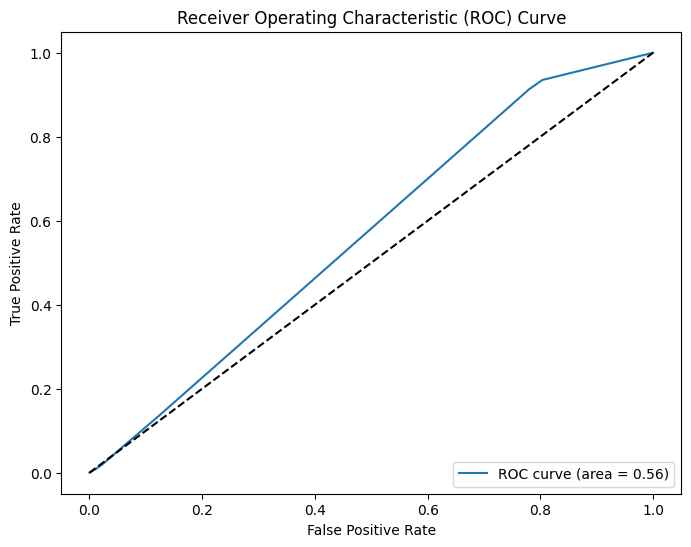

In [14]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y, income_data['predicted_prob'])
roc_auc = roc_auc_score(y, income_data['predicted_prob'])

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


Does education level affect the salary

In [15]:
# Cap the outliers at the 1st and 99th percentiles
lower_bound = income_data['lab_salary'].quantile(0.001)
upper_bound = income_data['lab_salary'].quantile(0.999)

income_data['lab_salary'] = np.where(income_data['lab_salary'] < lower_bound, lower_bound,
                                  np.where(income_data['lab_salary'] > upper_bound, upper_bound,
                                           income_data['lab_salary']))

In [16]:
income_data = income_data[(income_data['lab_amount'] == 1)]
income_data['lab_salary'].describe()


count    7.596000e+03
mean     8.251327e+03
std      2.683577e+04
min      1.130000e+02
25%      2.000000e+03
50%      4.000000e+03
75%      8.000000e+03
max      1.900000e+06
Name: lab_salary, dtype: float64

In [17]:
def Test_normally_distributed(group1, name):
    ks_eval = stats.kstest(group1, 'norm', args=(np.mean(group1), np.std(group1)))
    print(f"Kolmogorov-Smirnov Test for {name}: W={ks_eval[0]}, p-value={ks_eval[1]}")

    with open(f"{file_output}/hyp_2_norm_dist_{name}.tex", "w") as f:
        res = pd.DataFrame({
            r"W": {"Value": ks_eval[0]},
            r"$p$": {"Value": ks_eval[1]}
        })
        f.write(res.to_latex())

    if ks_eval.pvalue <= 0.05:
        print(f"The data is not normally distributed")
    else:
        print("The data is normally distributed")

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    stats.probplot(group1, dist="norm", plot=plt)
    plt.title(f'Q-Q Plot for {name}')
    
    plt.subplot(1, 2, 2)
    sns.histplot(group1, kde=True)
    plt.title(f'Hours Worked by {name} with KDE')

    plt.tight_layout()
    plt.savefig(f"{image_output}/hyp_2_norm_dist_{name}.svg", format='svg')
    plt.show()

Kolmogorov-Smirnov Test for income data: W=0.3808366599955252, p-value=0.0
The data is not normally distributed


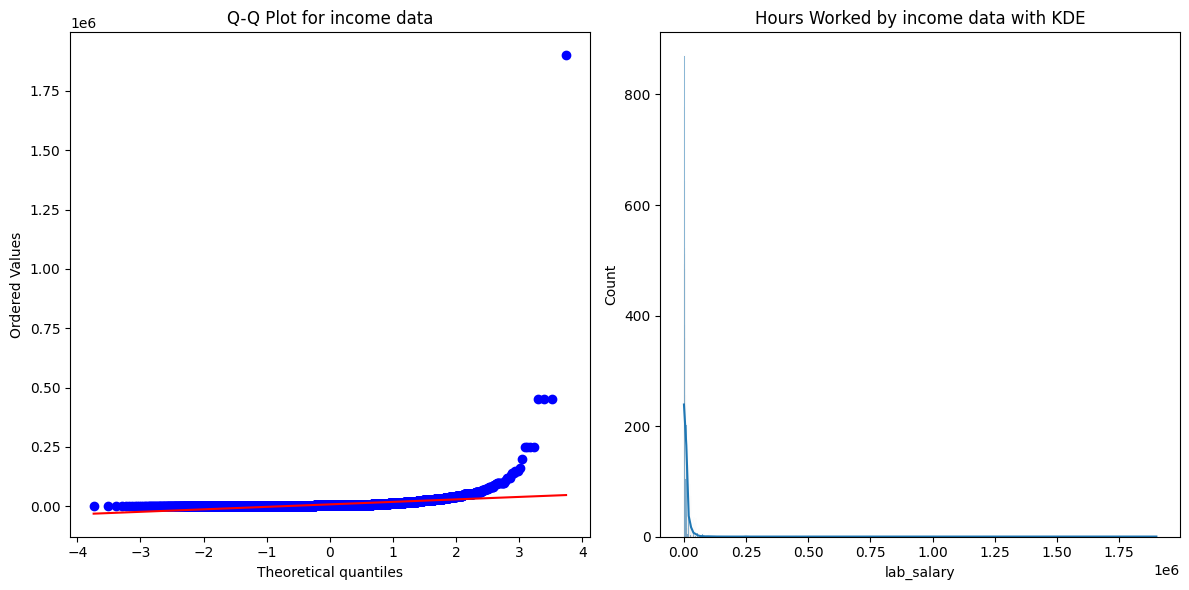

,sum_sq,df,F,PR(>F)
C(education_category),2.714025e+11,5.0,79.256069,2.583052e-81
Residual,5.198201e+12,7590.0,NaN,NaN


In [18]:
income_data = income_data[(income_data['lab_amount'] == 1) & (income_data['lab_salary'] < 88888888)]
income_data['education_category'] = income_data['education_category'].astype('category')

Test_normally_distributed(income_data["lab_salary"], "income data")

anova_model = ols('lab_salary ~ C(education_category)', data=income_data).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)

anova_table

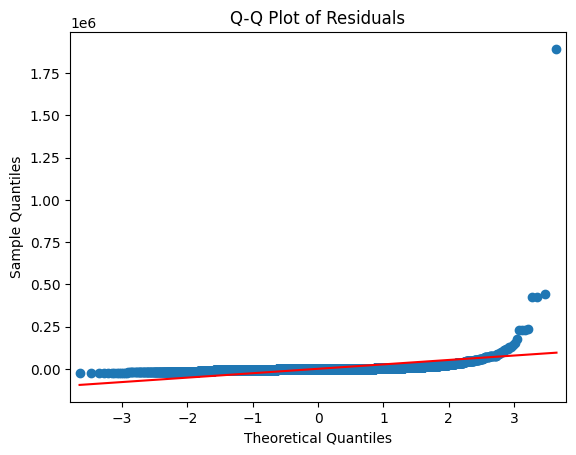

In [19]:
sm.qqplot(anova_model.resid, line='s')
plt.title("Q-Q Plot of Residuals")
plt.show()

In [20]:
shapiro_test = shapiro(anova_model.resid)

print("Shapiro-Wilk Test:")
print(f"Statistic: {shapiro_test.statistic}, p-value: {shapiro_test.pvalue}")

Shapiro-Wilk Test:
Statistic: 0.14878935751682, p-value: 2.437130427615727e-103


/home/27728277/School/Datasci/27728277-rw771-Data_Science_Project_2/.venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7596.
  res = hypotest_fun_out(*samples, **kwds)


In [21]:
from scipy.stats import levene
# Perform Levene's test
levene_test = levene(
                    *[group['lab_salary'] for name, group in income_data.groupby('education_category', observed=False)]
                    ) # Add more groups if necessary

print("Levene's Test for Homogeneity of Variances:")
print(f"Statistic: {levene_test.statistic}, p-value: {levene_test.pvalue}")

Levene's Test for Homogeneity of Variances:
Statistic: 36.50832449734521, p-value: 4.359639682161794e-37


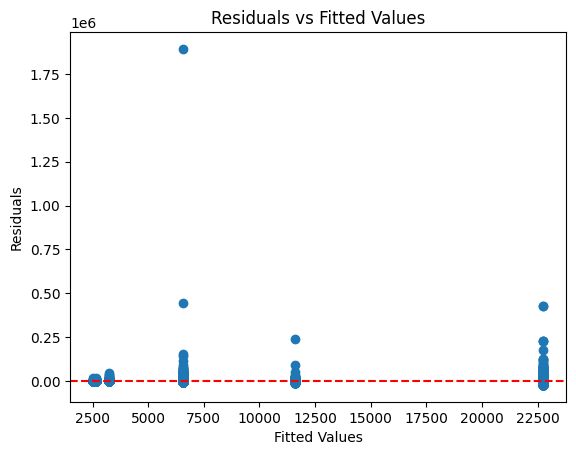

In [22]:
# Residual plot to check for patterns
plt.scatter(anova_model.fittedvalues, anova_model.resid)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

In [23]:
groups = [group['lab_salary'].values for name, group in income_data.groupby('education_category', observed=False)]
kruskal_statistic, kruskal_p_value = kruskal(*groups)

print(kruskal_statistic)
kruskal_p_value

1709.9194919405247


np.float64(0.0)

In [24]:
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm

model = sm.OLS.from_formula('lab_salary ~ education_category', data=income_data).fit()
welch = anova_lm(model, robust='hc3')

print(f"Welch's ANOVA statistic: {welch}")

Welch's ANOVA statistic:                         df        sum_sq       mean_sq          F  \
education_category     5.0  2.714025e+11  5.428049e+10  79.256069   
Residual            7590.0  5.198201e+12  6.848749e+08        NaN   

                          PR(>F)  
education_category  2.583052e-81  
Residual                     NaN  


In [25]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=income_data['lab_salary'], groups=income_data['education_category'], alpha=0.05)

# Display the results
print(tukey)

    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2  meandiff  p-adj    lower      upper    reject
------------------------------------------------------------
   0.0    1.0   146.1696    1.0 -8890.9816  9183.3208  False
   0.0    2.0   716.9395 0.9996 -5822.2837  7256.1628  False
   0.0    3.0  4066.4478 0.4293 -2176.4523 10309.3478  False
   0.0    4.0  9093.6363 0.0214   821.4486  17365.824   True
   0.0    5.0 20253.1632    0.0 13678.1491 26828.1773   True
   1.0    2.0   570.7699 0.9999 -6409.3992  7550.9391  False
   1.0    3.0  3920.2782 0.5538 -2783.0884 10623.6447  False
   1.0    4.0  8947.4667 0.0368   322.4791 17572.4543   True
   1.0    5.0 20106.9936    0.0 13093.2834 27120.7039   True
   2.0    3.0  3349.5082 0.0014   894.6228  5804.3936   True
   2.0    4.0  8376.6968 0.0009  2420.0408 14333.3527   True
   2.0    5.0 19536.2237    0.0 16329.4385 22743.0089   True
   3.0    4.0  5027.1886 0.1113  -602.5638 10656.9409  False
   3.0    5.0 16186.7155

### Hypothesis 3: are older people more fairly compensated in their salary
- Null Hypothesis (H₀): Age does not significantly affect salary compensation.
 - Alternative Hypothesis (H₁): Age significantly affects salary compensation.

In [84]:
lower_bound = income_data['lab_salary'].quantile(0.01)
upper_bound = income_data['lab_salary'].quantile(0.99)

income_data['lab_salary'] = np.where(income_data['lab_salary'] < lower_bound, lower_bound,
                                  np.where(income_data['lab_salary'] > upper_bound, upper_bound,
                                           income_data['lab_salary']))


In [85]:
income_data[['age', 'log_salary', 'education_category']].head()

,age,log_salary,education_category
58,40,8.630522,2.0
60,27,8.006368,2.0
65,44,8.188689,0.0
67,34,8.517193,2.0
68,28,8.333270,3.0


In [86]:
from scipy.stats import pearsonr
corr_stat, p_value = pearsonr(income_data['age'], income_data['lab_salary'])
print(f"Pearson Correlation: {corr_stat}, p-value: {p_value}")

Pearson Correlation: 0.12524258921175738, p-value: 6.1578537421482905e-28


In [87]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(income_data[['age']])



In [88]:
X = sm.add_constant(X_scaled)  # Add constant for intercept
y = income_data['lab_salary']
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             lab_salary   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     121.0
Date:                Sun, 29 Sep 2024   Prob (F-statistic):           6.16e-28
Time:                        16:40:35   Log-Likelihood:                -80742.
No. Observations:                7596   AIC:                         1.615e+05
Df Residuals:                    7594   BIC:                         1.615e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7499.8120    114.778     65.342      0.000    7274.815    7724.809
x1          1262.6421    114.778     11.001      0.000    1037.645    1487.639
==============================================================================
Omnibus:                     4613.002   Durbin-Watson:                   1.322
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            40504.665
Skew:                           2.885   Prob(JB):                         0.00
Kurtosis:                      12.730   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [89]:

gls_model = sm.GLS(y, X)
results = gls_model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            GLS Regression Results                            
==============================================================================
Dep. Variable:             lab_salary   R-squared:                       0.016
Model:                            GLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     121.0
Date:                Sun, 29 Sep 2024   Prob (F-statistic):           6.16e-28
Time:                        16:40:36   Log-Likelihood:                -80742.
No. Observations:                7596   AIC:                         1.615e+05
Df Residuals:                    7594   BIC:                         1.615e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7499.8120    114.778     65.342      0.000    7274.815    7724.809
x1          1262.6421    114.778     11.001      0.000    1037.645    1487.639
==============================================================================
Omnibus:                     4613.002   Durbin-Watson:                   1.322
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            40504.665
Skew:                           2.885   Prob(JB):                         0.00
Kurtosis:                      12.730   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [90]:
robust_model = model.get_robustcov_results()
robust_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             lab_salary   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     117.0
Date:                Sun, 29 Sep 2024   Prob (F-statistic):           4.51e-27
Time:                        16:40:37   Log-Likelihood:                -80742.
No. Observations:                7596   AIC:                         1.615e+05
Df Residuals:                    7594   BIC:                         1.615e+05
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7499.8120    114.778     65.342      0.000    7274.815    7724.809
x1          1262.6421    116.730     10.817      0.000    1033.820    1491.464
==============================================================================
Omnibus:                     4613.002   Durbin-Watson:                   1.322
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            40504.665
Skew:                           2.885   Prob(JB):                         0.00
Kurtosis:                      12.730   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

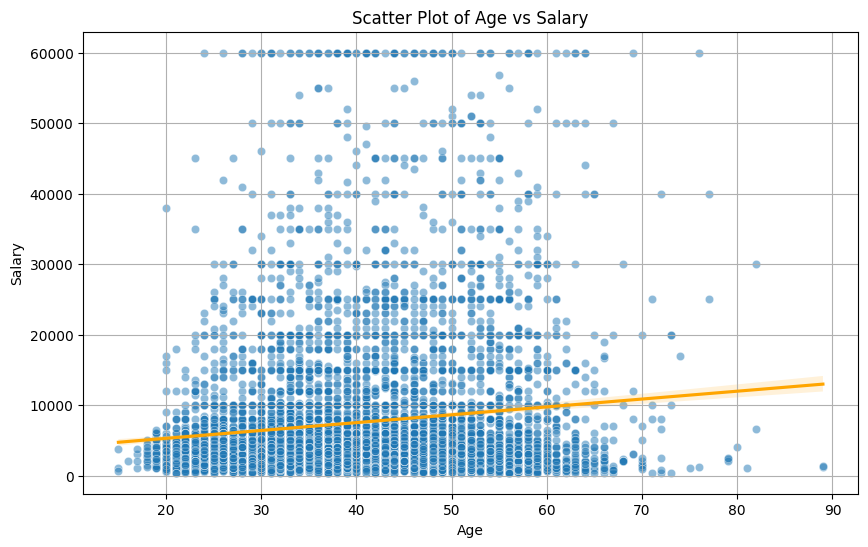

In [91]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=income_data, x='age', y='lab_salary', alpha=0.5)
sns.regplot(data=income_data, x='age', y='lab_salary', scatter=False, color='orange')
plt.title('Scatter Plot of Age vs Salary')
plt.xlabel('Age')
plt.ylabel('Salary')
plt.grid(True)
plt.show()

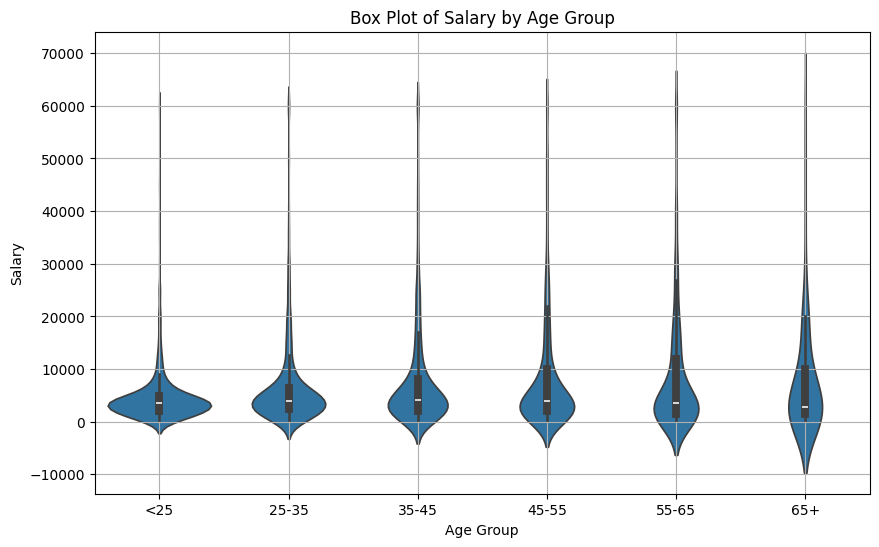

In [92]:
age_bins = [0, 25, 35, 45, 55, 65, 75]
age_labels = ['<25', '25-35', '35-45', '45-55', '55-65', '65+']
income_data['age_group'] = pd.cut(income_data['age'], bins=age_bins, labels=age_labels)

# Box plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=income_data, x='age_group', y='lab_salary')
plt.title('Box Plot of Salary by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Salary')
plt.grid(True)
plt.show()

/tmp/ipykernel_131688/3462847159.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_salary_by_age = income_data.groupby('age_group')['lab_salary'].mean().reset_index()


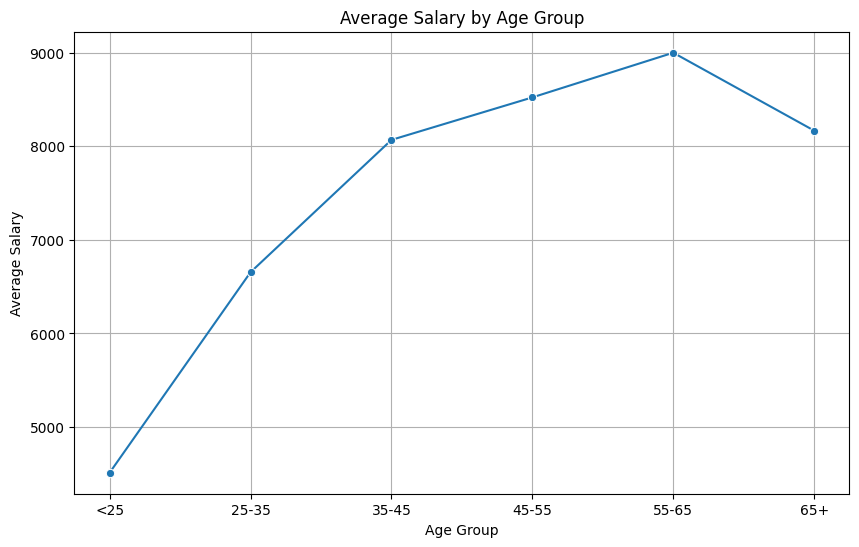

In [93]:
avg_salary_by_age = income_data.groupby('age_group')['lab_salary'].mean().reset_index()


plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_salary_by_age, x='age_group', y='lab_salary', marker='o')
plt.title('Average Salary by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Average Salary')
plt.grid(True)
plt.show()

/tmp/ipykernel_131688/4294448316.py:10: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = pd.pivot_table(income_data, values='lab_salary', index='age_group', columns='salary_group', aggfunc='count')


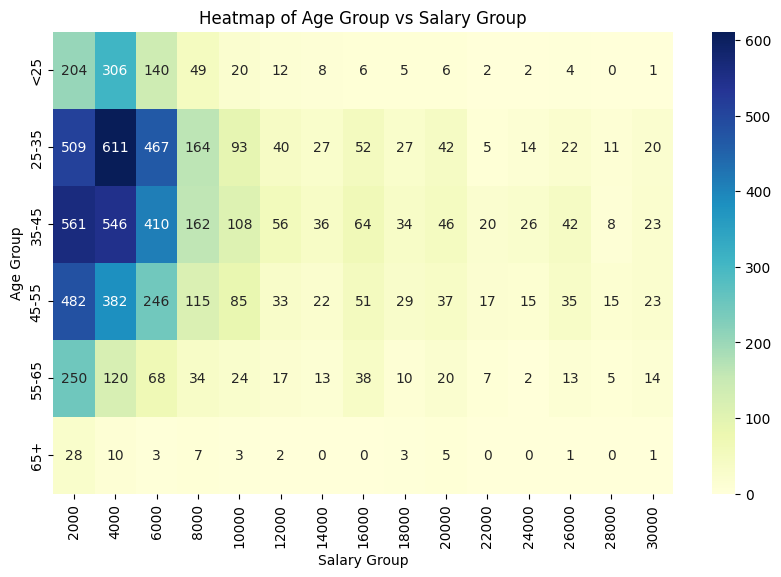

In [94]:
band_size = 2000

salary_bins = [i for i in range(0, 30000 + band_size, band_size)]
salary_labels = salary_bins[1:]
# salary_labels = ['<20K', '20K-40K', '40K-60K', '60K-80K', '80K-100K', '100K+']
income_data['salary_group'] = pd.cut(income_data['lab_salary'], bins=salary_bins, labels=salary_labels)


# Create a pivot table for heatmap
heatmap_data = pd.pivot_table(income_data, values='lab_salary', index='age_group', columns='salary_group', aggfunc='count')

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='g')
plt.title('Heatmap of Age Group vs Salary Group')
plt.xlabel('Salary Group')
plt.ylabel('Age Group')
plt.show()

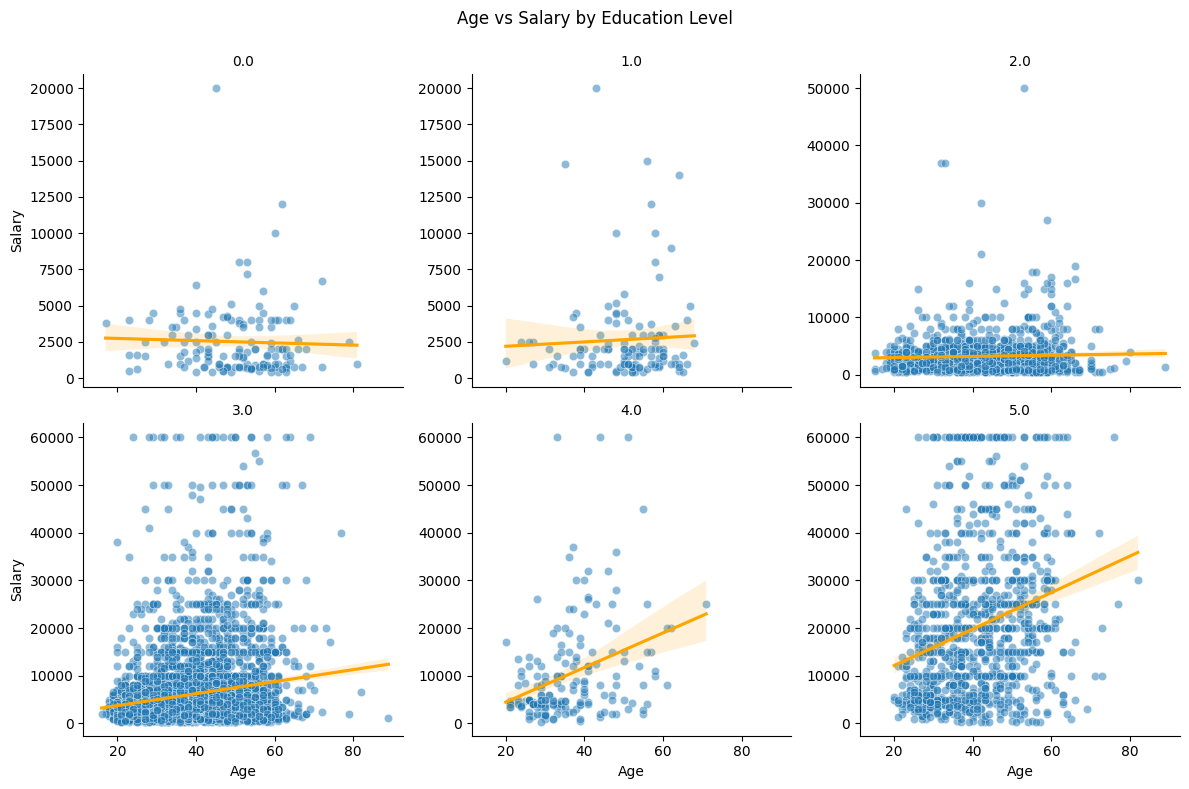

In [95]:
g = sns.FacetGrid(income_data, col="education_category", col_wrap=3, height=4, sharey=False)
g.map(sns.scatterplot, "age", "lab_salary", alpha=0.5)
g.map(sns.regplot, "age", "lab_salary", scatter=False, color='orange')
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Age", "Salary")
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Age vs Salary by Education Level')
plt.show()

### Hypothesis: Gender and equality

Gender and Salary

- Null Hypothesis (H₀): Gender does not significantly affect salary.
- Alternative Hypothesis (H₁): Gender significantly affects salary.

Gender and Education Level

- Null Hypothesis (H₀): Gender does not significantly affect education level.
- Alternative Hypothesis (H₁): Gender significantly affects education level.

In [97]:
male_salary = income_data[income_data['Sex'] == 'Male']['lab_salary']
female_salary = income_data[income_data['Sex'] == 'Female']['lab_salary']

In [98]:
male_salary.describe()

count     4047.000000
mean      8115.843588
std      10639.709019
min        400.000000
25%       2500.000000
50%       4500.000000
75%       8000.000000
max      60000.000000
Name: lab_salary, dtype: float64

In [99]:
female_salary.describe()

count     3549.000000
mean      6797.338123
std       9358.432553
min        400.000000
25%       1800.000000
50%       3500.000000
75%       6500.000000
max      60000.000000
Name: lab_salary, dtype: float64

In [100]:
from scipy.stats import ttest_ind
# Separate the data into two groups based on gender
male_salary = income_data[income_data['Sex'] == 'Male']['lab_salary']
female_salary = income_data[income_data['Sex'] == 'Female']['lab_salary']

# Perform an independent t-test
t_stat, p_value = ttest_ind(male_salary, female_salary)

print(f"T-test statistic: {t_stat}, p-value: {p_value}")

T-test statistic: 5.698363709009883, p-value: 1.2548704463892713e-08


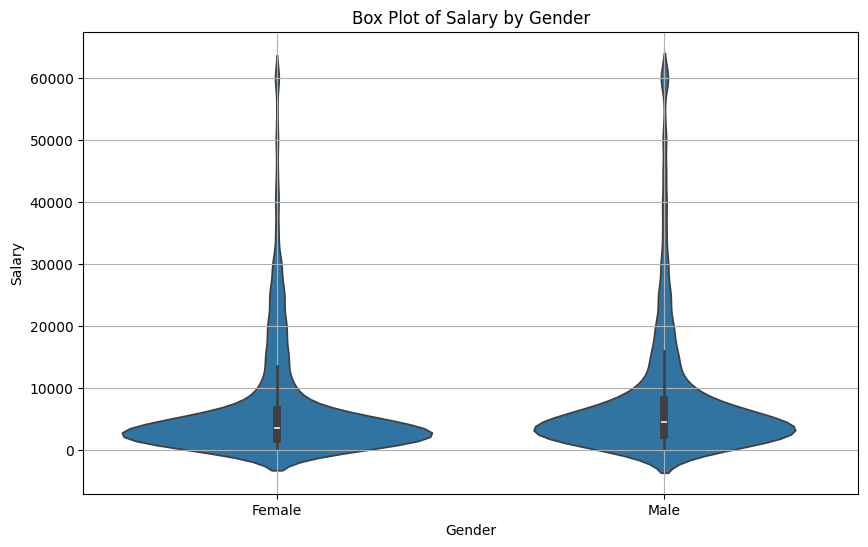

In [101]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=income_data, x='Sex', y='lab_salary')
plt.title('Box Plot of Salary by Gender')
plt.xlabel('Gender')
plt.ylabel('Salary')
plt.grid(True)
plt.show()

In [102]:
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(income_data['Sex'], income_data['education_category'])

# Perform the Chi-Squared test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Squared statistic: {chi2_stat}, p-value: {p_value}")

Chi-Squared statistic: 64.29572227823076, p-value: 1.568755074251703e-12


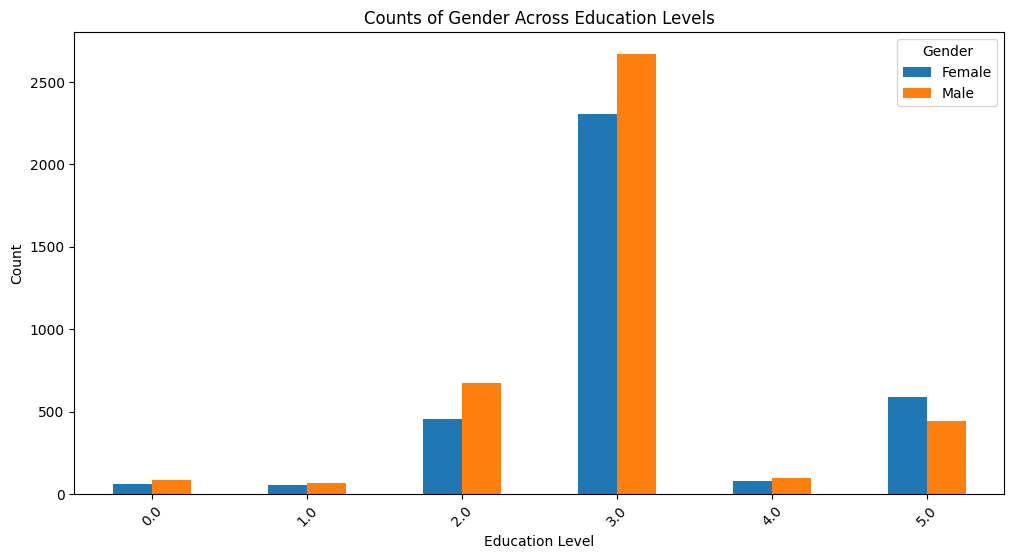

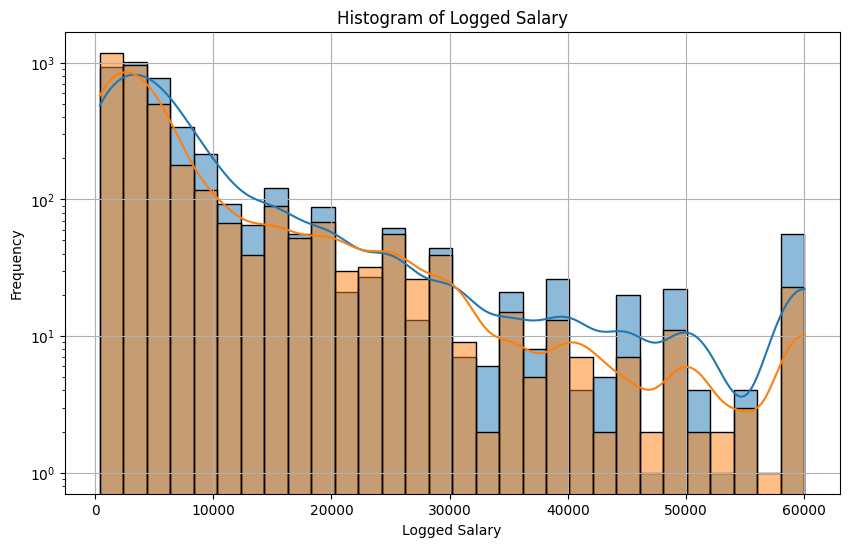

In [103]:
education_gender_count = pd.crosstab(income_data['education_category'], income_data['Sex'])

# Plot the bar chart
education_gender_count.plot(kind='bar', figsize=(12, 6))
plt.title('Counts of Gender Across Education Levels')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Gender')
plt.show()

plt.figure(figsize=(10, 6))
plt.yscale('log')
plt.subplot()
sns.histplot(male_salary, bins=30, kde=True)
plt.title('Histogram of Logged Salary')
plt.xlabel('Logged Salary')
plt.ylabel('Frequency')
plt.grid(True)

plt.subplot()
sns.histplot(female_salary, bins=30, kde=True)
plt.title('Histogram of Logged Salary')
plt.xlabel('Logged Salary')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Define Hypotheses:

- Null Hypothesis (H₀): There is no significant difference in salary based on race, controlling for education level.
- Alternative Hypothesis (H₁): There is a significant difference in salary based on race, controlling for education level.

ANOVA F-statistic: 434.07443592152055, p-value: 2.775474998390603e-260


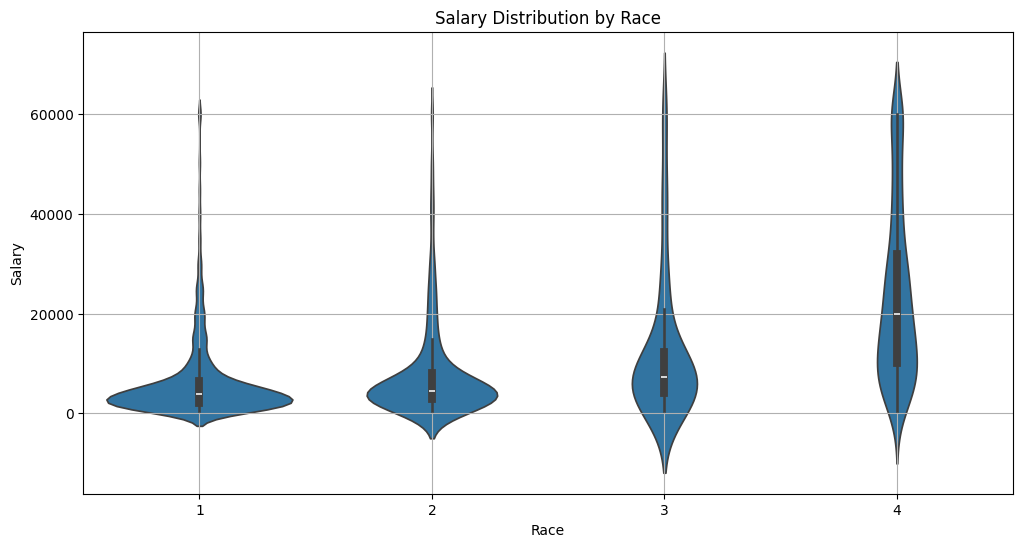

In [104]:
anova_result = stats.f_oneway(
    *[group['lab_salary'].values for name, group in income_data.groupby('Population')]
)

print(f"ANOVA F-statistic: {anova_result.statistic}, p-value: {anova_result.pvalue}")

# If you find significant results, visualize the differences
plt.figure(figsize=(12, 6))
sns.violinplot(x='Population', y='lab_salary', data=income_data)
plt.title('Salary Distribution by Race')
plt.ylabel('Salary')
plt.xlabel('Race')
plt.grid(True)
plt.show()

In [105]:
# Model: Salary ~ Race + Education Level
model = ols('lab_salary ~ C(Population) + C(education_category)', data=income_data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

                             sum_sq      df           F         PR(>F)
C(Population)          6.452200e+10     3.0  322.331190  5.397111e-197
C(education_category)  1.527688e+11     5.0  457.910309   0.000000e+00
Residual               5.062375e+11  7587.0         NaN            NaN


# Clustering

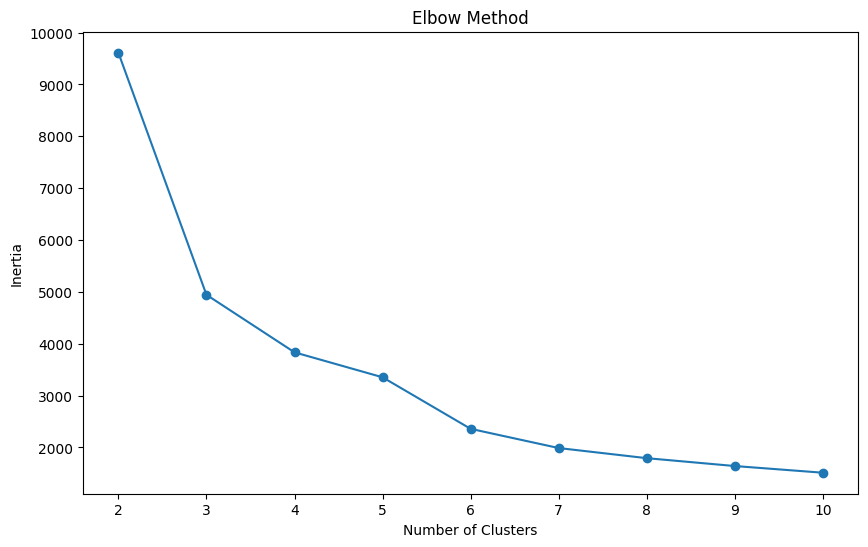

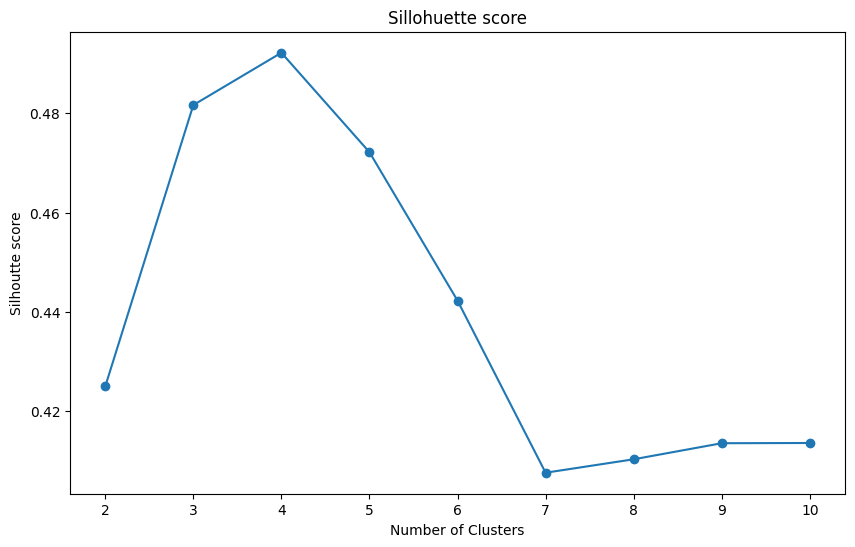

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

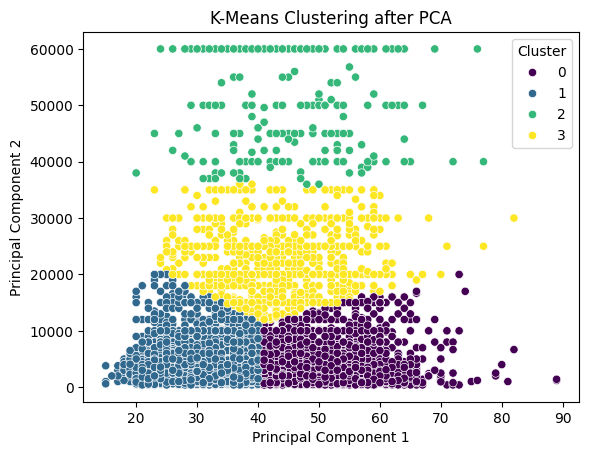

In [117]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
# Load your dataset

# Select relevant features for clustering
features = ['age', 'lab_salary']
X = income_data[features]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
# X_scaled = pca.fit_transform(X_scaled)

# Determine the optimal number of clusters using the elbow method
inertia = []
sil_score = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    labels = kmeans.labels_
    sil_score.append(silhouette_score(X_scaled, labels))

# Plot the elbow method
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), sil_score, marker='o')
plt.title('Sillohuette score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhoutte score')
plt.show()

# Choose the optimal number of clusters, e.g., 3
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
income_data['Cluster'] = kmeans.fit_predict(X_scaled)

sns.scatterplot(data=income_data, x='age', y='lab_salary', hue='Cluster', palette='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-Means Clustering after PCA')
plt.colorbar(label='Cluster')
plt.show()

/tmp/ipykernel_131688/2070954812.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_data['Population'] = cluster_data['Population'].astype('str')
/tmp/ipykernel_131688/2070954812.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_data['education_category'] = cluster_data['education_category'].astype('str')
/tmp/ipykernel_131688/2070954812.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

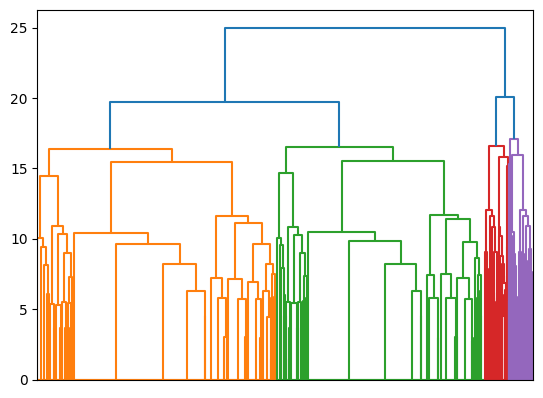

In [121]:
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
import gower

cluster_data = income_data[income_data["soc_grant"] < 3]

cluster_labels = ['age_group','education_category', 'Population', 'employ_Status2', "Sex", "soc_grant"]
cluster_data['Population'] = cluster_data['Population'].astype('str')
cluster_data['education_category'] = cluster_data['education_category'].astype('str')
cluster_data['employ_Status2'] = cluster_data['employ_Status2'].astype('str')
cluster_data['age_group'] = cluster_data['age_group'].astype('str')
cluster_data['soc_grant'] = cluster_data['soc_grant'].astype('str')
# print(cluster_data)

# from scipy.spatial.distance import pdist, squareform

gower_distance = gower.gower_matrix(cluster_data[cluster_labels])

linked = linkage(gower_distance, method='average')
dendrogram(linked, no_labels=True)
plt.show()

# # Standardize the data
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
# X_scaled = pca.fit_transform(X_scaled)

# # Apply DBSCAN
# dbscan = DBSCAN(eps=0.5, min_samples=5)
# income_data['Cluster'] = dbscan.fit_predict(X_scaled)

# # Step 4: Visualize the clusters
# plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=income_data['Cluster'], cmap='viridis')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.title('K-Means Clustering after PCA')
# plt.colorbar(label='Cluster')
# plt.show()

array([[0. , 0.6, 0.6, ..., 0.8, 0.6, 0.8],
       [0.6, 0. , 0.4, ..., 0.4, 0.4, 0.4],
       [0.6, 0.4, 0. , ..., 0.4, 0.2, 0.4],
       ...,
       [0.8, 0.4, 0.4, ..., 0. , 0.4, 0.2],
       [0.6, 0.4, 0.2, ..., 0.4, 0. , 0.4],
       [0.8, 0.4, 0.4, ..., 0.2, 0.4, 0. ]], dtype=float32)

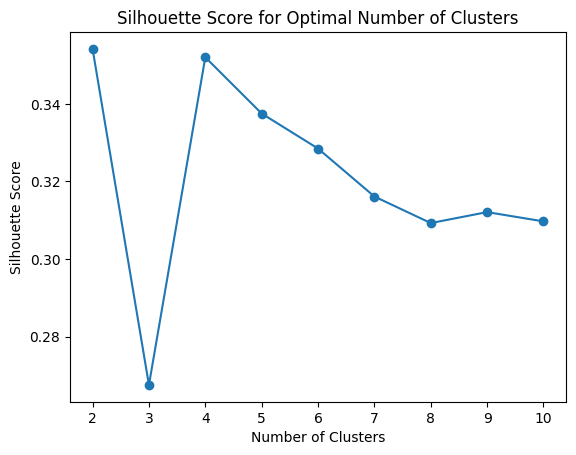

In [120]:
silhouette_scores = []
for i in range(2, 11):
    clusters = fcluster(linked, i, criterion='maxclust')
    score = silhouette_score(gower_distance, clusters, metric='precomputed')  # Using precomputed Gower distance
    silhouette_scores.append(score)

# Plot silhouette scores
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Number of Clusters')
plt.show()

In [124]:
cluster_data["hierachy_clusters"] = fcluster(linked, i, criterion='maxclust')

cluster_data

/tmp/ipykernel_131688/186874916.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_data["hierachy_clusters"] = fcluster(linked, i, criterion='maxclust')


,uqnr,personnr,psu,prov,Four_by_Four,Sex,age,age_grp1,Population,Languages,...,rotation,person_wgt,education-name,education_category,predicted_prob,log_salary,age_group,salary_group,Cluster,hierachy_clusters
58,161100010000087501,1,16110001000,1,1,Female,40,9,2,1,...,2,809.177395,Grade 6/Standard 4,2.0,0.435481,8.630522,35-45,6000,1,5
60,161100270000000301,1,16110027000,1,1,Male,27,6,1,8,...,2,888.806574,Grade 6/Standard 4,2.0,0.435481,8.006368,25-35,4000,1,2
65,161100270000011101,1,16110027000,1,1,Male,44,9,1,8,...,2,949.163333,No Schooling,0.0,0.601024,8.188689,35-45,4000,0,2
67,161100270000018301,1,16110027000,1,1,Male,34,7,1,8,...,2,1022.099704,Grade 5/Standard 3/ABET/AET 2,2.0,0.435481,8.517193,25-35,6000,1,2
68,161100270000029101,1,16110027000,1,1,Male,28,6,1,8,...,2,888.806574,Grade 10/Standard 8/Form 3/NCV Level 2/OCCUPAT...,3.0,0.355683,8.333270,25-35,6000,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67779,985103940000007301,1,98510394000,9,1,Female,47,10,1,7,...,1,499.647690,Diploma with Grade 12/Standard 10/OCCUPATIONAL...,5.0,0.220387,9.729134,45-55,18000,3,4
67888,985105310000008601,1,98510531000,9,1,Female,44,9,1,7,...,3,663.791991,Grade 12/Standard 10/Form 5/National Senior Ce...,3.0,0.355683,7.600902,35-45,2000,0,4
67955,986100880000015601,1,98610088000,9,1,Male,58,12,1,7,...,3,551.220286,Grade 12/Standard 10/Form 5/National Senior Ce...,3.0,0.355683,9.546813,55-65,14000,0,2
67985,986100990000020601,1,98610099000,9,1,Male,36,8,1,7,...,3,888.314167,Diploma with Grade 12/Standard 10/OCCUPATIONAL...,5.0,0.220387,7.495542,35-45,2000,1,2
